<a href="https://colab.research.google.com/github/Jimmy586/MachineLearningJourney/blob/master/QueueLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   We will make DQN without training
*   Do observation preprocessing, observation stacking, reward formating, and experience replay
*   Training Loop, and training function



In [ ]:
!pip install opendatasets

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import opendatasets as od
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
od.download('https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jimmyclariel
Your Kaggle Key: ··········


100%|██████████| 734k/734k [00:00<00:00, 875kB/s]

In [ ]:
df = pd.read_csv('/content/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')
df = df.dropna()
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [ ]:
df = df.drop(df['gender'][df['gender'] == 'Other'].index, axis=0)

In [ ]:
for i, label in enumerate(np.unique(df['smoking_history'])):
    df['smoking_history'][df['smoking_history'] == label] = i

df['smoking_history'] = df['smoking_history'].astype('int64')

for i, label in enumerate(np.unique(df['gender'])):
    df['gender'][df['gender'] == label] = i
df['gender'] = df['gender'].astype('int64')

<ipython-input-9-1b02a3132a01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoking_history'][df['smoking_history'] == label] = i
<ipython-input-9-1b02a3132a01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoking_history'][df['smoking_history'] == label] = i
<ipython-input-9-1b02a3132a01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoking_history'][df['smoking_history'] == label] = i
<ipython-input-9-1b02a313

In [ ]:
df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000
mean,0.414375,41.888076,0.074863,0.039427,2.179502,27.320757,5.527529,138.057810,0.085015
std,0.492616,22.517206,0.263172,0.194610,1.889559,6.636853,1.070665,40.709469,0.278906
min,0.000000,0.080000,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.000000,0.000000,3.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,60.000000,0.000000,0.000000,4.000000,29.580000,6.200000,159.000000,0.000000
max,1.000000,80.000000,1.000000,1.000000,5.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
scaler = MinMaxScaler()

normalized_data = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
normalized_data.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000
mean,0.414375,0.523124,0.074863,0.039427,0.435900,0.202040,0.368642,0.263899,0.085015
std,0.492616,0.281747,0.263172,0.194610,0.377912,0.077461,0.194666,0.185043,0.278906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.299299,0.000000,0.000000,0.000000,0.158964,0.236364,0.090909,0.000000
50%,0.000000,0.537037,0.000000,0.000000,0.600000,0.202031,0.418182,0.272727,0.000000
75%,1.000000,0.749750,0.000000,0.000000,0.800000,0.228408,0.490909,0.359091,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X= df.drop('diabetes',axis=1)
Y= df['diabetes']
rus = RandomUnderSampler(random_state=2)
X_undersampled,y_undersampled = rus.fit_resample(X,Y)

In [ ]:
len(y_undersampled[y_undersampled == 0 ])
len(y_undersampled[y_undersampled == 1])

8500

In [ ]:
def PCA(X, num_components):
  X_meaned = X - np.mean(X, axis = 0)
  cov_mat = np.cov(X_meaned.astype(float), rowvar= False)
  eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  eigenvector_subset = sorted_eigenvectors[:,0:num_components]

  X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose()).transpose()

  return X_reduced

In [ ]:
PCA_X = PCA(X_undersampled, 6)

In [ ]:
PCA_X

array([[ 2.47947093e+01,  7.80155504e+00,  9.11419386e-01,
        -1.21548560e+00,  1.14396158e-01,  5.28121628e-01],
       [ 2.22444212e+01, -1.33879324e+01, -1.76754370e+00,
        -7.02005558e-01,  4.53997782e-01,  5.68941082e-01],
       [ 1.73857601e+01, -1.24265101e+01,  2.81053137e+00,
         4.79520778e-01, -4.22777157e-01, -4.55435863e-01],
       ...,
       [-1.16827643e+02,  2.89806791e+00, -2.20831396e+00,
        -2.80866865e+00,  4.46935681e-01, -5.42527427e-01],
       [-3.71592558e+01, -3.97526436e+00, -7.62954764e+00,
         1.17279185e+00, -3.63532179e-01, -4.08966632e-01],
       [-7.70028903e+01, -1.44535359e+00,  1.49735697e+00,
        -1.66216184e+00,  4.85984020e-01, -5.14698703e-01]])

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(PCA_X, y_undersampled, test_size = 0.2, random_state = 45)

In [ ]:
class K_means :
  def __init__(self, K):
    self.data = None
    self.K = K
    self.centroids = []
    return

  def get_random_centroid(self):
    centers =  random.sample(list(self.data),self.K)
    return np.array(centers)

  def update_centroid(self,cluster):
    new_centers =  np.array([np.mean(i,axis=0) for i in cluster])
    self.centroids =  new_centers
    return self.centroids

  def L2_distance(self, X1,X2):
    dist = X1-X2
    return np.sqrt(np.sum([i**2 for i in dist]))

  def clustering (self):
    clusters = [[] for _ in range(self.K)]
    for sample in self.data :
      dist = [self.L2_distance(i,sample) for i in self.centroids]
      clusters[np.argmin(dist,axis = 0)].append(sample)

    return np.array([np.array(i) for i in clusters], dtype= object)

  def fit (self,X, MAX_iter = 100000, update_threshold = 0.000000001):
    self.data =X
    self.centroids =  self.get_random_centroid()
    while(True):
      clusters = self.clustering()
      old_centers = self.centroids
      self.centroids = self.update_centroid(clusters)
      MAX_iter -=1
      if not(MAX_iter) or (np.sum(self.centroids - old_centers)< update_threshold):
        break

  def predict (self, X):
    pred = []
    for sample in X :
      dist = [self.L2_distance(i,sample) for i in self.centroids]
      pred.append(np.argmin(dist,axis=0))
    return pred

In [ ]:
model = K_means(2)
model.fit(X_train)
centroid_from_scratch =  model.centroids
centroid_from_scratch

array([[-7.67672354e+01,  8.54122280e-01, -5.25491607e-01,
        -1.02906482e-03,  1.87828685e-02, -8.88968730e-03],
       [ 3.02280397e+01, -2.34900800e-01,  2.35046444e-01,
         3.08139549e-03, -1.39587063e-02,  1.87872055e-03]])

In [ ]:
pred_from_scratch =  model.predict(X_test)

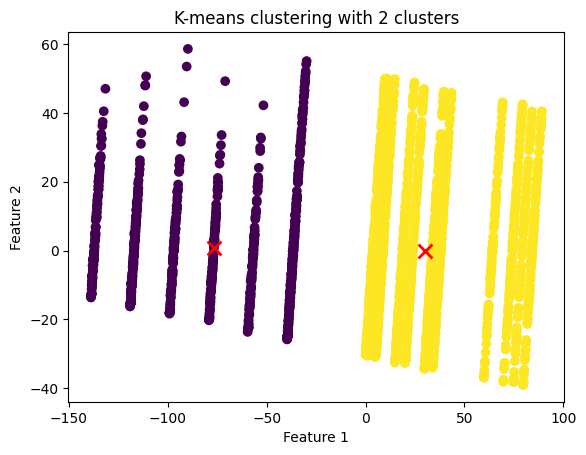

In [ ]:
def graph(pred_from_scratch):
  plt.scatter(X_test[:,0], X_test[:,1], c=pred_from_scratch)
  plt.scatter(centroid_from_scratch[:,0],centroid_from_scratch[:,1], marker = 'x',s=100,linewidth=2, color='red')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.title('K-means clustering with 2 clusters')
  plt.show()
  return

graph(pred_from_scratch)

In [ ]:
accuracy = 1- accuracy_score(y_test, pred_from_scratch)
accuracy

0.6979411764705883

# BUILTIN K-MEAN

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_train)
pred_kmean = kmeans.predict(X_test)
centroid_built_in = kmeans.cluster_centers_
centroid_built_in

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[ 2.97676825e+01, -5.02853333e-01, -3.94064145e-02,
        -7.46567192e-04, -1.69239842e-02,  4.75959820e-04],
       [-8.03664118e+01,  1.62078881e+00,  1.75055269e-01,
         9.03530501e-03,  2.82014797e-02, -5.61986236e-03]])

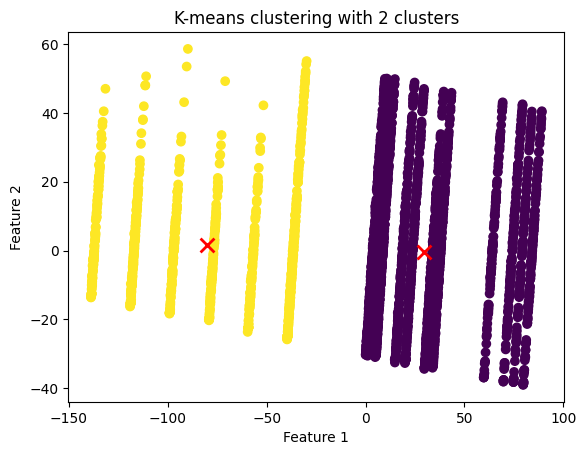

In [ ]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred_kmean)
plt.scatter(centroid_built_in[:,0], centroid_built_in[:,1], marker='x', s=100, linewidths=2,color="red")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means clustering with 2 clusters')
plt.show()

In [ ]:
pred = []
for i in pred_kmean:
  if i == 0:
    pred.append(1)
  else:
    pred.append(0)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.12      0.06      0.08      1695
           1       0.37      0.54      0.44      1705

    accuracy                           0.30      3400
   macro avg       0.24      0.30      0.26      3400
weighted avg       0.24      0.30      0.26      3400



In [ ]:
accuracy = 1- accuracy_score(y_test, pred_kmean)
accuracy

0.3020588235294117